##Setup



In [1]:
%pip install transformers==3.4.0

     |████████████████████████████████| 1.3MB 5.6MB/s 
     |████████████████████████████████| 890kB 9.4MB/s 
     |████████████████████████████████| 2.9MB 18.0MB/s 
     |████████████████████████████████| 1.2MB 51.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=876c07c28a25f5855e8934573f5e0bd30645dc16654801441a551f4e02af2fad
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
%tensorflow_version 2.x
import tensorflow as tf

import urllib
import unicodedata

import pandas as pd
import numpy as np
import os
import re
import json
import random
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
from transformers import BertTokenizerFast, TFBertForQuestionAnswering

In [3]:
TRAIN_FRACTION = 0.9
PRETRAINED_MODEL_NAME = 'nlpaueb/bert-base-greek-uncased-v1'

Starts the GPU

In order to enable the GPU:

* navigate to Edit→Notebook Settings
* select GPU from the Hardware Accelerator drop-down

In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


I retrieve the data-set at the below code cell. Due to some confidentiality concerns I can't share the data set.

In [ ]:
# TODO: add your data-set

##Data preparation

In [7]:
# load greek stop words
stop_words = []
with open(os.path.join('data', 'stop_words.txt'), 'r', encoding='utf-8') as stop_words_file:
    for line in stop_words_file.readlines():
        stop_words.append(line[:-1])       

In [8]:
def strip_accents_and_lowercase(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn').lower()

In [9]:
def text_processing(text):
    # to lowercase letters and remove all Greek diacritics
    lower_case_text = strip_accents_and_lowercase(text)
    # remove non words
    clean = re.sub("[^Α-ΩΆΈΌΊΏΉΎα-ωάέόίώήύϊϋ]", " ", lower_case_text)
    split_to_tokens = clean.split()
    split_to_tokens = [w for w in split_to_tokens if w not in stop_words]
    return ' '.join(split_to_tokens)

In [10]:
# read the json file with the annotated answers
with open(os.path.join('data', 'answers.json'), 'r', encoding='utf-8') as input_json:
    answers_json_file = json.loads(input_json.read())

# normalize json file to dataframe
answers_df = json_normalize(answers_json_file['data'])

with open(os.path.join('data', 'documents.json'), 'r', encoding='utf-8') as input_json:
    documents_json_file = json.loads(input_json.read())

documents_df = json_normalize(documents_json_file['data'])

# read the questions file
questions_df = pd.read_csv(os.path.join('data', 'questions.csv'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  # This is added back by InteractiveShellApp.init_path()


In [14]:
tokenizer = BertTokenizerFast.from_pretrained(PRETRAINED_MODEL_NAME)

Calculates the max number of tokens that the context, which contains the answer for a given question, can consist of.

In [15]:
tokens_num_of_longest_question = 0
for index, question in questions_df.iterrows():
  question_tokens = tokenizer.tokenize(question['original_question'])
  number_of_tokens = len(question_tokens)
  if number_of_tokens > tokens_num_of_longest_question:
    tokens_num_of_longest_question = number_of_tokens

print('The longest question consists of {} tokens '.format(str(tokens_num_of_longest_question)))

max_num_of_ctx_tokens = 512 - tokens_num_of_longest_question - 5
print('The context which contains the answer can be max {} tokens'.format(str(max_num_of_ctx_tokens)))

The longest question consists of 18 tokens 
The context which contains the answer can be max 489 tokens


In [16]:
def find_answer_in_doc(doc, answer):
  result = [x for x in range(len(doc)) if doc[x:x+len(answer)] == answer]
  if len(result) > 0:
    return result[0]
  
  return -1

Truncates the large documents so that the encoded context (which will be used for training) contains the answer text among the entire paragraph.

In [17]:
def truncate_doc_for_answer(document, answer):
  doc_length = len(document)
  answer_length = len(answer)

  tokenized_document = tokenizer.tokenize(document)
  tokenized_answer = tokenizer.tokenize(answer)

  doc_tokens_length = len(tokenized_document)
  answer_tokens_length = len(tokenized_answer)

  if doc_tokens_length <= max_num_of_ctx_tokens:
    return document

  token_answer_start = find_answer_in_doc(tokenized_document, tokenized_answer)
  token_answer_end = token_answer_start + answer_tokens_length - 1

  if token_answer_start == -1:
    print('WARNING: start_answer token is -1')
    return ""

  if answer_tokens_length <= max_num_of_ctx_tokens:
    if token_answer_start == 0:
      truncated_doc = tokenized_document[:max_num_of_ctx_tokens]
    elif token_answer_end == (doc_tokens_length - 1):
      truncated_doc = tokenized_document[-max_num_of_ctx_tokens:]
    else:
      rest = max_num_of_ctx_tokens - answer_tokens_length
      factor = round(random.uniform(0, 1), 1)

      from_left_take = int(factor * rest)
      start_at = token_answer_start - from_left_take
      if start_at < 0:
        start_at = 0
        from_left_take = token_answer_start
      
      from_right_take = rest - from_left_take
      end_at = token_answer_end + from_right_take
      end_at = end_at + 1
      if end_at >= doc_tokens_length:
        end_at = doc_tokens_length - 1

      truncated_doc = tokenized_document[start_at:end_at]
    
    truncated_doc = tokenizer.decode(tokenizer.convert_tokens_to_ids(truncated_doc))

  else:
    # case of long answer is excluding because it will be truncated by the tokenizer and it will affect the training 
    print('INFO: answer length is greater than max_num_of_ctx_tokens ({})'.format(str(max_num_of_ctx_tokens)))
    truncated_doc = ""

  return truncated_doc

Converts to the required input format

In [18]:
contexts = []
questions = []
answers = []

docs_length = []
anws_length = []
splitted_answers = 0

answer_start_per_question_dict = {}
for index, question in questions_df.iterrows():
  answer_start_per_question_dict[question['question_id']] = []

for index, row in answers_df.iterrows():
  document_content = documents_df.loc[documents_df['id'] == row['id'], 'content'].item()
  document_content = text_processing(document_content)
  docs_length.append(len(document_content))

  answer_list = row['results']

  for answer in answer_list:
    for question in answer['label']:
      question_id = question
      question_text = questions_df.loc[questions_df['question_id'] == question_id, 'original_question'].item()

      answer_text = answer['points'][0]['text']
      answer_text = text_processing(answer_text)

      anws_length.append(len(answer_text))
      current_value = answer_start_per_question_dict[question_id]
      current_value.append(answer['points'][0]['start'])
      answer_start_per_question_dict.update({question_id: current_value})

      truncated_doc = truncate_doc_for_answer(document_content, answer_text)

      answer_start = truncated_doc.find(answer_text)
      answer_end = answer_start + len(answer_text)

      if answer_start != -1:
        contexts.append(truncated_doc)
        questions.append(question_text)
        answers.append({"text": answer_text, "answer_start": answer_start, "answer_end": answer_end})
      else:
        print("WARNING: one answer with start index equal to -1 found") 

print(len(contexts))
print(len(questions))
print(len(answers))

INFO: answer length is greater than max_num_of_ctx_tokens (489)
INFO: answer length is greater than max_num_of_ctx_tokens (489)
INFO: answer length is greater than max_num_of_ctx_tokens (489)
INFO: answer length is greater than max_num_of_ctx_tokens (489)
INFO: answer length is greater than max_num_of_ctx_tokens (489)
INFO: answer length is greater than max_num_of_ctx_tokens (489)
INFO: answer length is greater than max_num_of_ctx_tokens (489)
INFO: answer length is greater than max_num_of_ctx_tokens (489)
INFO: answer length is greater than max_num_of_ctx_tokens (489)
INFO: answer length is greater than max_num_of_ctx_tokens (489)
INFO: answer length is greater than max_num_of_ctx_tokens (489)
INFO: answer length is greater than max_num_of_ctx_tokens (489)
INFO: answer length is greater than max_num_of_ctx_tokens (489)
INFO: answer length is greater than max_num_of_ctx_tokens (489)
INFO: answer length is greater than max_num_of_ctx_tokens (489)
INFO: answer length is greater than max_

##Exploratory Data Analysis (EDA)

Concerns the *original* documents not the truncated documents

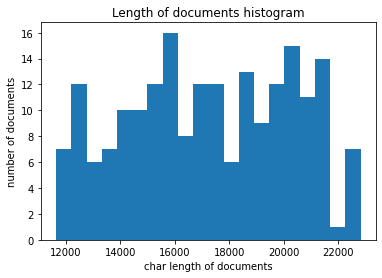

In [19]:
plt.hist(docs_length, bins = 20)
plt.title("Length of documents histogram")
plt.xlabel("char length of documents")
plt.ylabel("number of documents")
plt.show()

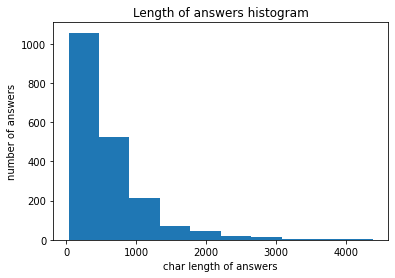

In [20]:
plt.hist(anws_length)
plt.title("Length of answers histogram")
plt.xlabel("char length of answers")
plt.ylabel("number of answers")
plt.show()

Displays the start indexes of the answers for each question

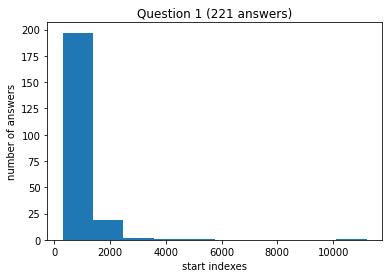

The average value for the start index is 919 



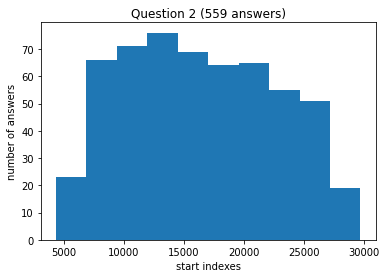

The average value for the start index is 16422 



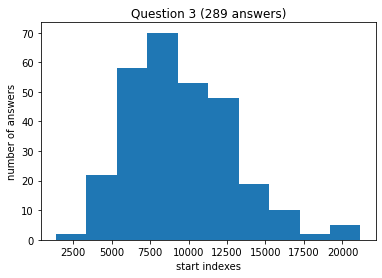

The average value for the start index is 9531 



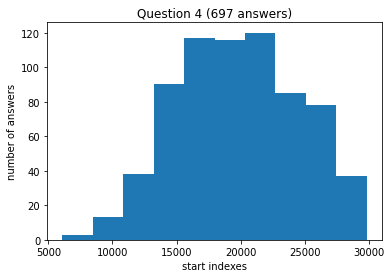

The average value for the start index is 19816 



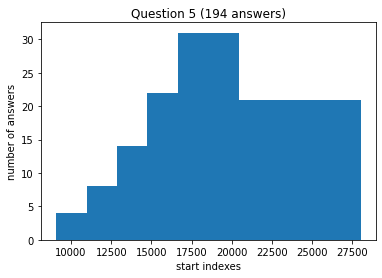

The average value for the start index is 19861 



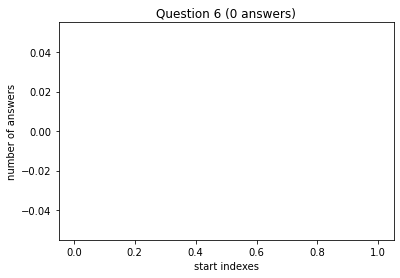

The average value for the start index is 0 



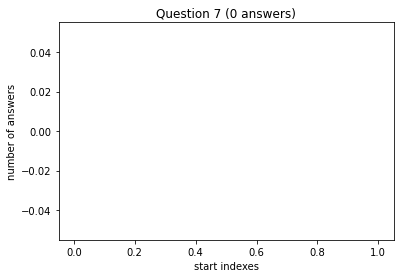

The average value for the start index is 0 



In [27]:
avg_start_index_per_question_dict = {}

for index, question in questions_df.iterrows():
  question_id = question['question_id']
  start_indexes = [0]
  if question_id in answer_start_per_question_dict:
    start_indexes = answer_start_per_question_dict[question_id]

  plt.hist(start_indexes)
  plt.title('Question ' + str(index + 1) + 
            ' (' + str(len(start_indexes))
             + ' answers)')
  plt.xlabel("start indexes")
  plt.ylabel("number of answers")
  plt.show()
  average_start_index = 0
  if len(start_indexes) > 0:
    average_start_index = int(sum(start_indexes) / len(start_indexes))
  print("The average value for the start index is {} \n".format(str(average_start_index)))
  avg_start_index_per_question_dict[question_id] = average_start_index

##Before training

Splits dataframes into train and validation datasets

In [28]:
index = int(TRAIN_FRACTION * len(contexts))
val_index = len(contexts) - index

train_contexts = contexts[:index] 
train_questions = questions[:index]
train_answers = answers[:index]

val_contexts = contexts[-(val_index):]
val_questions = questions[-(val_index):]
val_answers = answers[-(val_index):]

print('Train dataset size {}'.format(str(len(train_contexts))))
print('Validation dataset size {}'.format(str(len(val_contexts))))

Train dataset size 1741
Validation dataset size 194


Tokenizes the context/question pairs

In [29]:
train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True, max_length=512)

Converts the character start/end positions to token start/end positions

In [30]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))
        # if None, the answer passage has been truncated
        if start_positions[-1] is None:
            print('Start position is none')
            start_positions[-1] = 0 #tokenizer.model_max_length
        if end_positions[-1] is None:
            print('End position is none')
            end_positions[-1] = 500 #tokenizer.model_max_length
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

Creates datasets classes

In [31]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    {key: train_encodings[key] for key in ['input_ids', 'attention_mask']},
    {key: train_encodings[key] for key in ['start_positions', 'end_positions']}
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    {key: val_encodings[key] for key in ['input_ids', 'attention_mask']},
    {key: val_encodings[key] for key in ['start_positions', 'end_positions']}
))

##Training

In [32]:
train_dataset = train_dataset.map(lambda x, y: (x, (y['start_positions'], y['end_positions'])))
val_dataset = val_dataset.map(lambda x, y: (x, (y['start_positions'], y['end_positions'])))

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model = TFBertForQuestionAnswering.from_pretrained(PRETRAINED_MODEL_NAME)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=loss)

batch_size = 8
model.fit(train_dataset.shuffle(100).batch(batch_size),
          epochs=2,
          batch_size=batch_size,
          validation_data=val_dataset.shuffle(100).batch(batch_size))


Some layers from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 were not used when initializing TFBertForQuestionAnswering: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForQuestionAnswering were not initialized from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 and are newly initialized: ['qa_outputs']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
218/218 [==============================] - 146s 600ms/step - loss: 7.4300 - output_1_loss: 3.3596 - output_2_loss: 4.0704 - val_loss: 4.0541 - val_output_1_loss: 1.9667 - val_output_2_loss: 2.0873
Epoch 2/2
218/218 [==============================] - 128s 587ms/step - loss: 3.7082 - output_1_loss: 1.6326 - output_2_loss: 2.0756 - val_loss: 3.8051 - val_output_1_loss: 1.8767 - val_output_2_loss: 1.9284


In [33]:
model.summary()

Model: "tf_bert_for_question_answering"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  112921344 
_________________________________________________________________
qa_outputs (Dense)           multiple                  1538      
Total params: 112,922,882
Trainable params: 112,922,882
Non-trainable params: 0
_________________________________________________________________


##Prediction

In [34]:
with open(os.path.join('data', 'documents_test.json'), 'r', encoding='utf-8') as input_json:
    documents_to_predict_json_file = json.loads(input_json.read())

documents_to_predict_df = json_normalize(documents_to_predict_json_file['data'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  after removing the cwd from sys.path.


In [35]:
CHAR_NUM_TO_SPLIT_DOC = 1000

def split_document_into_chunks(document):
    return list((document[i:i+CHAR_NUM_TO_SPLIT_DOC] for i in range(0, len(document), CHAR_NUM_TO_SPLIT_DOC)))

In [36]:
SLIDING = 2000

def where_to_search(question_id, doc):
  if question_id not in avg_start_index_per_question_dict:
    return doc

  avg_start_index = avg_start_index_per_question_dict[question_id]
  start = avg_start_index - SLIDING
  if start < 0 :
    start = 0

  end = avg_start_index + (2*SLIDING)
  if end >= len(doc):
    end = len(doc) - 1

  return doc[start:end]

In [37]:
def predict_answer(question, context): 
  encoded_tokens =  tokenizer.encode_plus(question, context, 
                                          add_special_tokens=True,
                                          return_token_type_ids=True, 
                                          return_tensors="tf",
                                          truncation=False)
    
  token_ids = list(encoded_tokens["input_ids"].numpy()[0])

  answer_start_scores, answer_end_scores = model(encoded_tokens)  
  
  answer_start = tf.argmax(answer_start_scores, axis=1).numpy()[0] 
  answer_end = (tf.argmax(answer_end_scores, axis=1) + 1).numpy()[0]
  
  answer = ""
  if answer_end > answer_start:
    answer = tokenizer.decode(token_ids[answer_start:answer_end])
  
  #print("[chunk] Q: {} A: {}".format(question, answer))

  return answer

In [38]:
def batch_predict(questions, context):
  answers = []
  question_context_for_batch = []

  for question in questions :
      question_context_for_batch.append((question, context))

  encoding = tokenizer.batch_encode_plus(question_context_for_batch,
                                         return_token_type_ids=True,
                                         padding=True,
                                         return_tensors="tf")
  
  input_ids = list(encoding["input_ids"].numpy())
  start_scores, end_scores = model(encoding)

  for index,(start_score,end_score,input_id) in enumerate(zip(start_scores, end_scores, input_ids)):
      answer_start = tf.argmax(start_score)
      answer_end = tf.argmax(end_score)
     
      answer_tokens = input_ids[index][answer_start: answer_end + 1]
      answer = tokenizer.decode(answer_tokens)      
      answers.append(answer)

      #print("[chunk] Q: {} A: {}".format(questions[index], answer))

  return answers

In [ ]:
estimated_answers_df = pd.DataFrame(columns=['document_id', 'question_id', 'answer'])

for index, doc in documents_to_predict_df.iterrows():
  print('----- Document {} predictions -----'.format(str(index)))
  for q_index, question in questions_df.iterrows():
    question_id = question['question_id']
    doc_sub_part = where_to_search(question_id, doc['content'])
    document_chunks = split_document_into_chunks(doc_sub_part)
    
    answer = ''
    for chunk in document_chunks:
      sub_answer = predict_answer(question['original_question'], chunk)
      answer = answer + sub_answer

    if answer == '':
      answer = 'no answer'    
      
    print('RESULT: Question {} - answer {}'.format(str(question_id), str(answer)))

    estimated_answers_df = estimated_answers_df.append(
        {'document_id': doc['id'], 
        'question_id': question_id,
        'answer': answer},
        ignore_index=True)
    

    estimated_answers_df.to_csv(os.path.join('data', 'estimated_answers.csv'), index=False, encoding='utf-8')
  
  #break